# POS tagging using modified Viterbi

### <b><i>Using the TreeBank universal tag set corpus, build a Viterbi PoS tagger, then enhance it to solve the problem of unknown words.</b></i>

In this assignment, you need to modify the Viterbi algorithm to solve the problem of unknown words using at least two techniques. Though there could be multiple ways to solve this problem, you may use the following hints:
- Which tag class do you think most unknown words belong to? Can you identify rules (e.g. based on morphological cues) that can be used to tag unknown words? You may define separate python functions to exploit these rules so that they work in tandem with the original Viterbi algorithm.
- Why does the Viterbi algorithm choose a random tag on encountering an unknown word? Can you modify the Viterbi algorithm so that it considers only one of the transition or emission probabilities for unknown words?


### <b><i>Goals</b></i>

You can split the Treebank dataset into train and validation sets. Please use a sample size of 95:5 for training: validation sets, i.e. keep the validation size small, else the algorithm will need a very high amount of runtime. 

You need to accomplish the following in this assignment:

- Write the vanilla Viterbi algorithm for assigning POS tags (i.e. without dealing with unknown words) 
- Solve the problem of unknown words using at least two techniques. These techniques can use any of the approaches discussed in the class - lexicon, rule-based, probabilistic etc. Note that to implement these techniques, you can either write separate functions and call them from the main Viterbi algorithm, or modify the Viterbi algorithm, or both.
- Compare the tagging accuracy after making these modifications with the vanilla Viterbi algorithm.
- List down at least three cases from the sample test file (i.e. unknown word-tag pairs) which were incorrectly tagged by the original Viterbi POS tagger and got corrected after your modifications.

## 1. Data Preparation

In [1]:
#Importing libraries
import pandas as pd
import numpy as np
import random
import time

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import nltk
from nltk import corpus
from nltk.tokenize import word_tokenize

pd.options.display.max_rows = 100

In [23]:
# reading the Treebank tagged sentences
nltk.download('treebank')
nltk.download('universal')
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

[nltk_data] Error loading treebank: <urlopen error [WinError 10060] A
[nltk_data]     connection attempt failed because the connected party
[nltk_data]     did not properly respond after a period of time, or
[nltk_data]     established connection failed because connected host
[nltk_data]     has failed to respond>
[nltk_data] Error loading universal: <urlopen error [WinError 10060] A
[nltk_data]     connection attempt failed because the connected party
[nltk_data]     did not properly respond after a period of time, or
[nltk_data]     established connection failed because connected host
[nltk_data]     has failed to respond>


In [24]:
# lets check first few tagged sentences
nltk_data[:5]

[[('Pierre', 'NOUN'),
  ('Vinken', 'NOUN'),
  (',', '.'),
  ('61', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  (',', '.'),
  ('will', 'VERB'),
  ('join', 'VERB'),
  ('the', 'DET'),
  ('board', 'NOUN'),
  ('as', 'ADP'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
  ('director', 'NOUN'),
  ('Nov.', 'NOUN'),
  ('29', 'NUM'),
  ('.', '.')],
 [('Mr.', 'NOUN'),
  ('Vinken', 'NOUN'),
  ('is', 'VERB'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Elsevier', 'NOUN'),
  ('N.V.', 'NOUN'),
  (',', '.'),
  ('the', 'DET'),
  ('Dutch', 'NOUN'),
  ('publishing', 'VERB'),
  ('group', 'NOUN'),
  ('.', '.')],
 [('Rudolph', 'NOUN'),
  ('Agnew', 'NOUN'),
  (',', '.'),
  ('55', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  ('and', 'CONJ'),
  ('former', 'ADJ'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Consolidated', 'NOUN'),
  ('Gold', 'NOUN'),
  ('Fields', 'NOUN'),
  ('PLC', 'NOUN'),
  (',', '.'),
  ('was', 'VERB'),
  ('named', 'VERB'),
  ('*-1', 'X'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
 

In [25]:
#lets divide the dataset into training and test set
train_set, test_set = train_test_split(nltk_data, train_size=0.95, random_state=45)
print(len(train_set))
print(len(test_set))

3718
196


In [26]:
# get list of all the tagged words in training set
tagged_training_words = [tup for pair in train_set for tup in pair]
tagged_training_words[:5]

[('Fujitsu', 'NOUN'),
 ('and', 'CONJ'),
 ('NEC', 'NOUN'),
 ('said', 'VERB'),
 ('0', 'X')]

In [27]:
# get all the distinct tags and words to create a tagset and vocabulary
tags = set([tag for (word,tag) in tagged_training_words])
training_vocabulary = set([word.lower() for (word,tag) in tagged_training_words])
print(len(tags))
print(len(training_vocabulary))

12
11129


## 2. POS Tagging Algorithm - HMM


We'll use the HMM algorithm to tag the words. Given a sequence of words to be tagged, the task is to assign the most probable tag to the word. 

In other words, to every word w, assign the tag t that maximises the likelihood P(t/w). Since P(t/w) = P(w/t). P(t) / P(w), after ignoring P(w), we have to compute P(w/t) and P(t).


P(w/t) is basically the probability that given a tag (say NN), what is the probability of it being w (say 'building'). This can be computed by computing the fraction of all NNs which are equal to w, i.e. 

P(w/t) = count(w, t) / count(t). 


The term P(t) is the probability of tag t, and in a tagging task, we assume that a tag will depend only on the previous tag. In other words, the probability of a tag being NN will depend only on the previous tag t(n-1). So for e.g. if t(n-1) is a JJ, then t(n) is likely to be an NN since adjectives often precede a noun (blue coat, tall building etc.).


Given the penn treebank tagged dataset, we can compute the two terms P(w/t) and P(t) and store them in two large matrices. The matrix of P(w/t) will be sparse, since each word will not be seen with most tags ever, and those terms will thus be zero. 

### Emission Probabilities

P(w|t) = 

            Number of times w has been tagged t
        ----------------------------------------------    
               Number of times t appears

In [28]:
# Create a function to compute emission probability
def compute_emission_probability(vocab,tags):
    emission_df = pd.DataFrame(index=vocab, columns=tags).fillna(0)
    for (word,tag) in tagged_training_words:
        emission_df.loc[word.lower(),tag] = emission_df.loc[word.lower(),tag] + 1
    for tag in tags:
        emission_df[tag] = emission_df[tag] / emission_df[tag].sum()
    return emission_df


In [29]:
# Create an Emission Probability Dataframe
emission_prob_dataframe = compute_emission_probability(training_vocabulary,tags)
emission_prob_dataframe.head()

,NOUN,ADV,VERB,PRON,NUM,PRT,X,ADP,CONJ,ADJ,DET,.
17.4,0.000000,0.000000,0.000000,0.0,0.000297,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ubs,0.000036,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
individuals,0.000328,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sees,0.000000,0.000000,0.000155,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
anyway,0.000000,0.000332,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Transition Probabilities

P(t2|t1) =  
        
         Number of times t1 is followed by tag t2
        ----------------------------------------------- 
                  Number of times t1 appears

In [30]:
# Create empty dataframe 
transition_prob_dataframe = pd.DataFrame(index=list(tags), columns=list(tags)).fillna(0)

# Create a function to compute transition probability
def transition_probability(i, tag, sentence):
    prev_tag = sentence[i-1][1] if i else '.'
    transition_prob_dataframe.loc[prev_tag,tag] = transition_prob_dataframe.loc[prev_tag,tag]+1

# Create a function for transition probability dataframe
def compute_transtion_probability(data):    
    for sentence in data:
        for index , tup in enumerate(sentence):
            transition_probability(index, tup[1], sentence)
    for tag in tags:
        transition_prob_dataframe.loc[tag] = transition_prob_dataframe.loc[tag]/ transition_prob_dataframe.loc[tag].sum()
    return transition_prob_dataframe

In [31]:
# Create an Transition Probability Dataframe
transition_prob_dataframe =compute_transtion_probability(nltk_data)
transition_prob_dataframe.head()

,NOUN,ADV,VERB,PRON,NUM,PRT,X,ADP,CONJ,ADJ,DET,.
NOUN,0.264256,0.016986,0.146982,0.004680,0.009464,0.043921,0.029015,0.176795,0.042604,0.012133,0.013069,0.240094
ADV,0.031546,0.079495,0.344795,0.015142,0.031546,0.014196,0.023028,0.118612,0.006940,0.129653,0.068770,0.136278
VERB,0.110366,0.081834,0.168977,0.035535,0.022855,0.031407,0.217782,0.091345,0.005382,0.065173,0.134326,0.035019
PRON,0.209353,0.033979,0.485568,0.007673,0.007307,0.012422,0.092802,0.022653,0.005115,0.073073,0.009499,0.040555
NUM,0.353273,0.002822,0.018059,0.001411,0.185102,0.027088,0.210497,0.034989,0.013544,0.033296,0.003104,0.116817


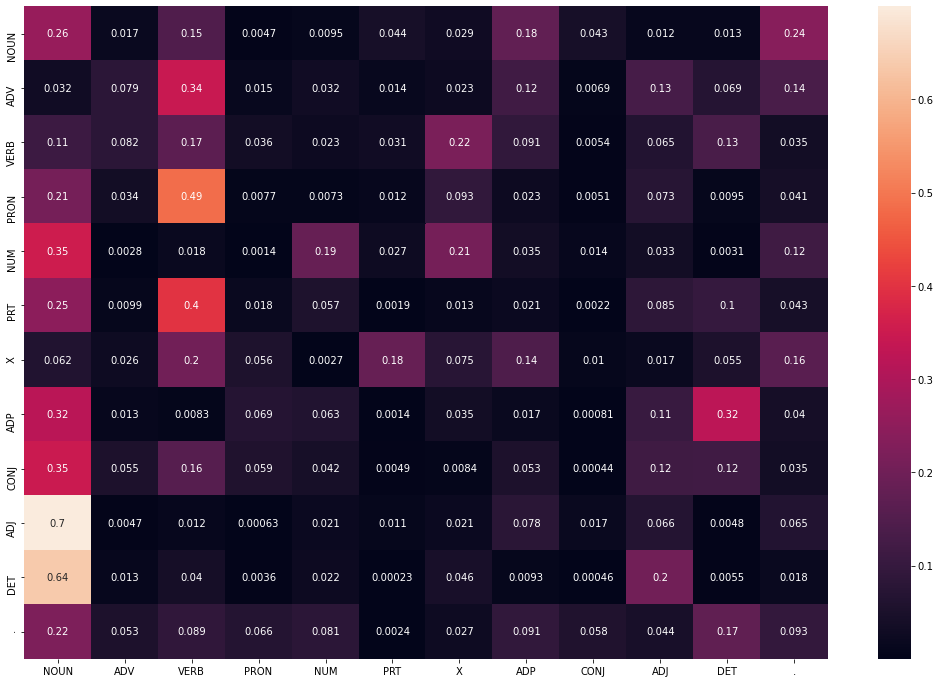

In [32]:
# Plot a heatmap for transition probability
plt.figure(figsize=(18, 12))
sns.heatmap(transition_prob_dataframe,annot=True)
plt.show()

## 3. Viterbi Algorithm
Let's now use the computed probabilities emission and transition to assign tags to each word in the document. We'll run through each word w and compute P(tag/w)=P(w/tag).P(tag) for each tag in the tag set, and then assign the tag having the max P(tag/w).

We'll store the assigned tags in a list of tuples, similar to the list 'tagged_training_words'. Each tuple will be a (word, assigned_tag). As we progress further in the list, each tag to be assigned will use the tag of the previous token.

Note: P(tag|start) = P(tag|'.')

In [33]:
# Create a function for vanilla viterbi
def vanilla_viterbi(words, paired = tagged_training_words):
    tags = list(set([tag for (word,tag) in paired]))
    state_list = []
    for index,word in enumerate(words):
        state_prob_list = []

        for tag in tags:
            # fetch  previous tag and calculate transition probability
            prev_tag= state_list[index-1] if index else '.'
            t_prob = transition_prob_dataframe.loc[prev_tag,tag]
            try:
                # compute emission probability for word
                e_prob = emission_prob_dataframe.loc[word.lower(),tag]
            except:
                # For unknown word emission probability = 0
                e_prob = 0
            finally:
                # Calculate state probability 
                state_prob = e_prob * t_prob
                state_prob_list.append(state_prob)

        # find the max probability out of all state probability
        max_prob = max(state_prob_list)
        state_list.append(tags[state_prob_list.index(max_prob)])

    return list(zip(words,state_list))

## 4. Evaluating on test set

In [34]:
#Create lists of words from test set
test_tagged_words = [word for sentence in test_set for (word,tag) in sentence]

In [35]:
# Let's test our Viterbi algorithm on a few sample sentences of test dataset
start_time = time.time()
vanilla_viterbi_list=[]

# append the sentences to viterbi list to test
for sentence in test_set:
  sequence = vanilla_viterbi(test_tagged_words)
  vanilla_viterbi_list.append(sequence)

end_time = time.time()



In [36]:
# calculate time taken to execute
time_diff = end_time - start_time
runtime_for_viterbi_vanilla = round(time_diff,4)
print("Runtime for Vanilla Viterbi", runtime_for_viterbi_vanilla, 'sec') 

Runtime for Vanilla Viterbi 467.4282 sec


In [37]:
# create a function to flatten the viterbi list
def flatten_viterbi_list(viterbi_list_to_flatten):
    converted = [lst for viterbi in viterbi_list_to_flatten for lst in viterbi]
    return converted

# Create a function to return a list of tuples with word, assigned and the actual tag
def combine_word_tags(assigned_list,original_list):
    return [(assigned[0], assigned[1], original[1]) for assigned,original in zip(assigned_list,original_list) if assigned[0]==original[0] ]

# Create a function for words with assigned and actual tags
def create_tagged_test_df(test_data_list, assigned_tag_list):
    original_tag_list = [tup for sentence in test_data_list for tup in sentence]
    tagged_test_dataframe = pd.DataFrame(combine_word_tags(assigned_tag_list,original_tag_list),columns=['Word','Assigned_Tag','Original_Tag'])
    return tagged_test_dataframe

# Create a function to find the accuracy of vanilla viterbi
def get_accuracy(df):
    return round(len(df[df['Original_Tag']==df['Assigned_Tag']]) / len(df) * 100, 2)

In [38]:
# Flattened list
flattened_viterbi_list = flatten_viterbi_list(vanilla_viterbi_list)

In [39]:
# Create tagged test dataframe of words for assigned and actual tags
tagged_test_dataframe = create_tagged_test_df(test_set,flattened_viterbi_list)
tagged_test_dataframe.head()

,Word,Assigned_Tag,Original_Tag
0,In,ADP,ADP
1,the,DET,DET
2,U.S.,NOUN,NOUN
3,over-the-counter,ADJ,ADJ
4,market,NOUN,NOUN


In [40]:
# Calculate the accuracy of Vanilla Viterbi
accurancy_for_vanilla_viterbi = get_accuracy(tagged_test_dataframe)
print("Accuracy of Vanilla Viterbi: "+str(accurancy_for_vanilla_viterbi) +"%")

Accuracy of Vanilla Viterbi: 93.58%


In [41]:
# Create a function to get incorrectly tagged words
def get_incorrect_tagged_words(df):
    return df[df['Original_Tag'] != df['Assigned_Tag']]

# Get incorrectly tagged words
incorrect_tagged_words_df = get_incorrect_tagged_words(tagged_test_dataframe)
print("Count of Incorrect Tags:",len(incorrect_tagged_words_df))

Count of Incorrect Tags: 316


Let's find out number of unknown words present in our dataset. So unknown words are the ones present in test_set but not in train_set

In [42]:
# Find unknown words
unknown_words_in_dataset = list(set(test_tagged_words) - set(training_vocabulary))
print("Total Unknown Words count: ", str(len(unknown_words_in_dataset)))
print("Sampling Unknown words: " , unknown_words_in_dataset[:10])

Total Unknown Words count:  632
Sampling Unknown words:  ['Fields', 'Technology', 'Funny', 'Steven', 'Asia', 'NEC', 'jeopardy', 'Securities', 'Mexican', 'predispose']


There are a lot of unknown words, which must be getting tagged to any arbitrary tag. Thus the problem of unknown words should be handled.

## 5. Solve the problem of unknown words


The emission probabilities for all tags will be 0 for unknown words, so the algorithm arbitrarily chooses a tag. Thus we need to solve the problem of unknown tags

- Viterbi for unknown words with transition probability
- Viterbi with lexicon taggers


## Technique 1: Viterbi for Unknown words with transition probability only

    - If word exist, 
              state probability = emission probability x transition probability 

    - While if the word doesn't exist, 
             state probability = transition probability 




In [43]:
# function to assign tags using viterbi
def viterbi_for_unknown_words(words,paired=tagged_training_words):
    tags = list(set([tag for (word,tag) in paired]))
    state_list = []
    for index,word in enumerate(words):
        state_prob_list = []

        for tag in tags:
            # fetch  previous tag and calculate transition probability
            prev_tag= state_list[index-1] if index else '.'
            t_prob = transition_prob_dataframe.loc[prev_tag,tag]
            try:
                # compute emission probability for word
                e_prob = emission_prob_dataframe.loc[word.lower(),tag]
            except:
                # For unknown word emission probability = 0
                e_prob = 1
            finally:
                # Calculate state probability 
                state_prob = e_prob * t_prob
                state_prob_list.append(state_prob)

        # find the max probability out of all state probability
        max_prob = max(state_prob_list)
        state_list.append(tags[state_prob_list.index(max_prob)])

    return list(zip(words,state_list))

In [44]:
# Let's test our Viterbi algorithm on a few sample sentences of test dataset
start_time = time.time()
viterbi_for_unknown_word_sequence_list = []

for sentence in test_set:
    sequence = viterbi_for_unknown_words([word for (word,tag) in sentence])
    viterbi_for_unknown_word_sequence_list.append(sequence)

end_time = time.time()

In [45]:
# calculate time taken to execute
time_diff = end_time - start_time
runtime_for_viterbi_for_unknown_word = round(time_diff,4)
print("Runtime for Viterbi for unknown words with transition prob:", runtime_for_viterbi_for_unknown_word, 'sec') 

Runtime for Viterbi for unknown words with transition prob: 6.1548 sec


In [46]:
# Flaten the viterbi list
flattened_viterbi_for_unknown_word_list = flatten_viterbi_list(viterbi_for_unknown_word_sequence_list)
# Create tagged test dataframe of words for assigned and actual tags
viterbie_for_unknown_word_dataframe = create_tagged_test_df(test_set,flattened_viterbi_for_unknown_word_list)
viterbie_for_unknown_word_dataframe.head()

,Word,Assigned_Tag,Original_Tag
0,In,ADP,ADP
1,the,DET,DET
2,U.S.,NOUN,NOUN
3,over-the-counter,ADJ,ADJ
4,market,NOUN,NOUN


In [47]:
# Calculate the accuracy of Modifed Viterbi
accuracy_for_viterbi_unknown_word = get_accuracy(viterbie_for_unknown_word_dataframe)
print("Accuracy for Viterbi with transition prob only: "+str(accuracy_for_viterbi_unknown_word) +"%")

Accuracy for Viterbi with transition prob only: 93.31%


## Technique 2: Lexicon and Rule-Based Models for POS Tagging

#### Check patterns to create rules for rule based tagger

In [48]:
# Check Patterns present in the words and Plot chart
def check_pattern(pattern, pair_list):
    check_list = [(word,tag) for sentence in pair_list for (word,tag) in sentence if word.endswith(pattern)]
    check_df = pd.DataFrame(check_list,columns=['words','tags'])

    values = pd.Series(check_df['tags'].value_counts())
    values = round(values / values.sum() * 100,2)
    
    plt.figure(figsize=(10,6))
    values.plot.bar()
    return values

VERB    58.02
NOUN    32.82
ADJ      7.34
ADP      1.82
Name: tags, dtype: float64

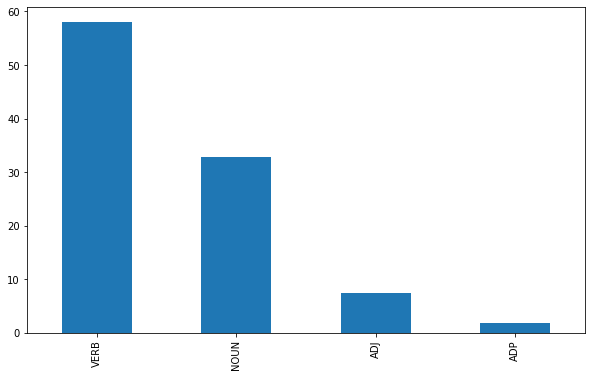

In [49]:

check_pattern('ing',train_set)

**Rule : Tag words ending with 'ing' as VERB**

VERB    87.69
ADJ      9.58
NOUN     2.27
ADV      0.33
NUM      0.10
ADP      0.03
Name: tags, dtype: float64

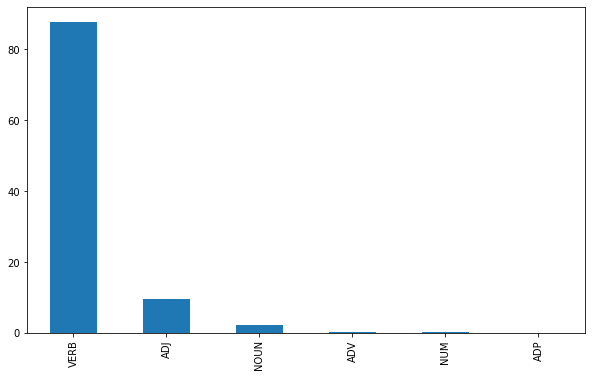

In [50]:
check_pattern('ed',train_set)

**Rule : Tag words ending with 'ed' as VERB**

NOUN    98.28
ADJ      0.98
VERB     0.74
Name: tags, dtype: float64

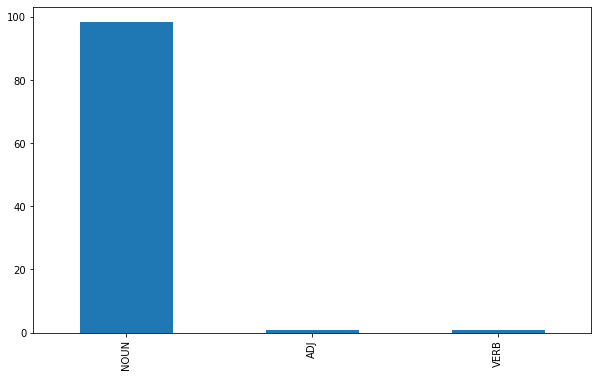

In [51]:
check_pattern('tion',train_set)

**Rule : Tag words ending with 'tion' as NOUN**

ADV     83.54
ADJ      9.64
NOUN     6.23
VERB     0.58
Name: tags, dtype: float64

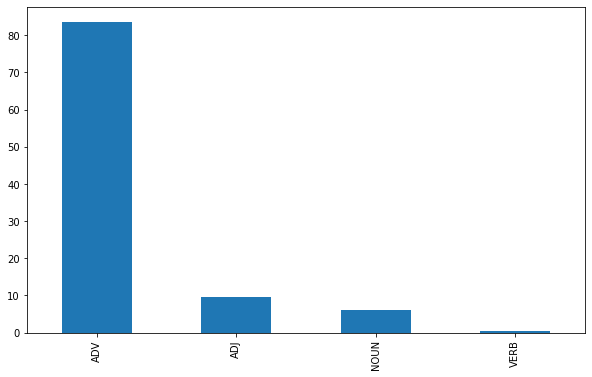

In [52]:
check_pattern('ly',train_set)

**Rule : Tag words ending with 'ly' as ADV**

NOUN    99.09
ADJ      0.91
Name: tags, dtype: float64

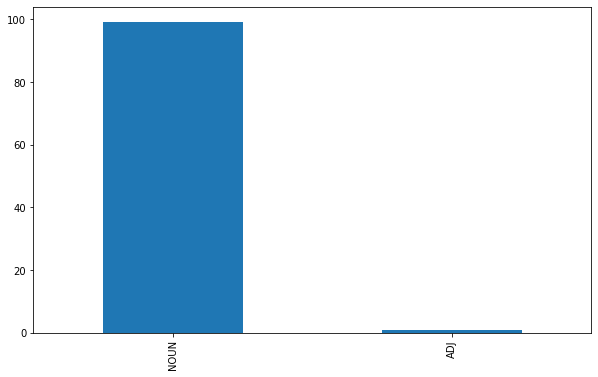

In [53]:
check_pattern('ness',train_set)

**Rule : Tag words ending with 'ness' as NOUN**

NOUN    83.00
VERB    15.60
PRON     0.56
ADV      0.51
ADP      0.19
ADJ      0.14
Name: tags, dtype: float64

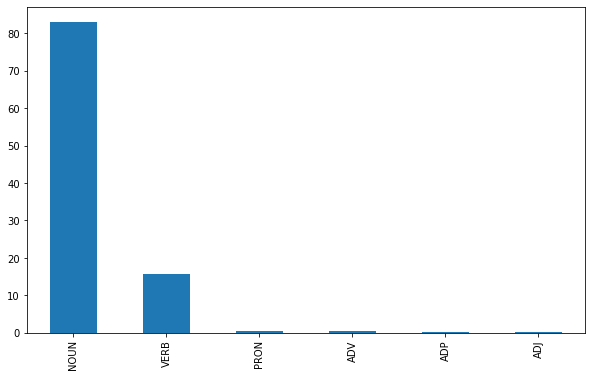

In [54]:
check_pattern('es',train_set)

**Rule : Tag words ending with 'es' as NOUN**

ADJ     54.05
ADV     20.27
NOUN    13.51
ADP     10.81
VERB     1.35
Name: tags, dtype: float64

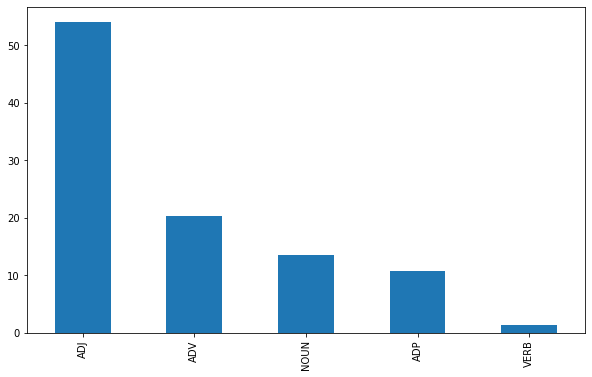

In [55]:
check_pattern('less',train_set) 

**Rule : Tag words ending with 'less' as ADJ**

ADJ     94.12
NOUN     5.88
Name: tags, dtype: float64

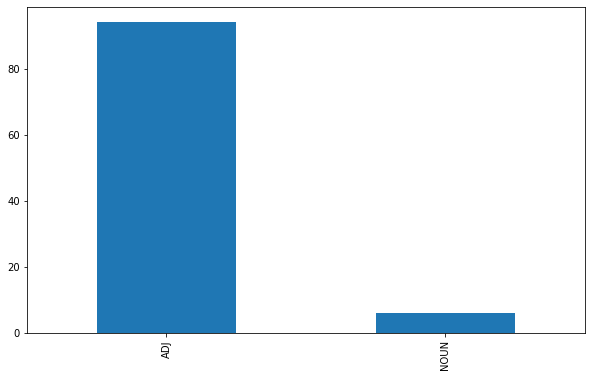

In [56]:
check_pattern('ful',train_set)

**Rule : Tag words ending with 'ful' as ADJ**

NOUN    51.80
ADJ     20.49
ADP     12.33
ADV      6.94
DET      3.00
PRON     2.53
VERB     2.30
PRT      0.47
CONJ     0.14
Name: tags, dtype: float64

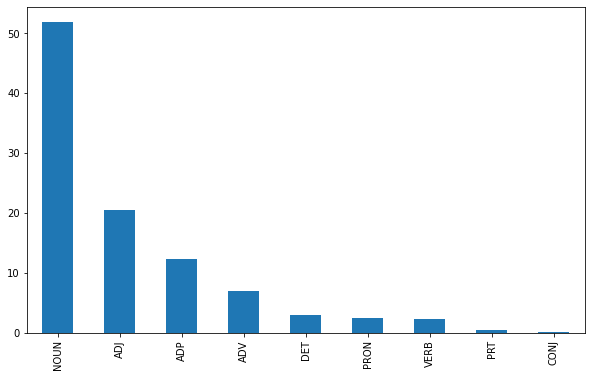

In [57]:
check_pattern('er',train_set)

**Rule : Tag words ending with 'er' as NOUN**

ADJ     64.79
NOUN    34.10
VERB     1.02
ADV      0.09
Name: tags, dtype: float64

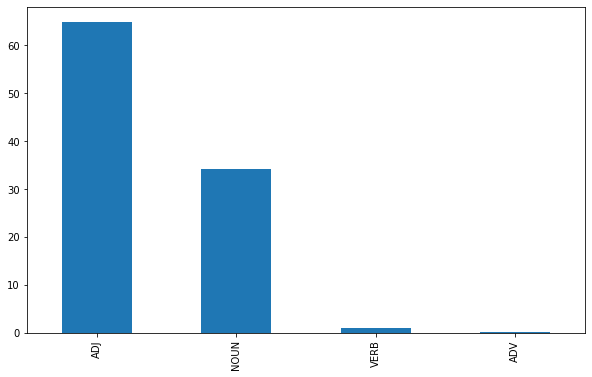

In [58]:
check_pattern('al',train_set)

**Rule : Tag words ending with 'al' as ADJ**

VERB    100.0
Name: tags, dtype: float64

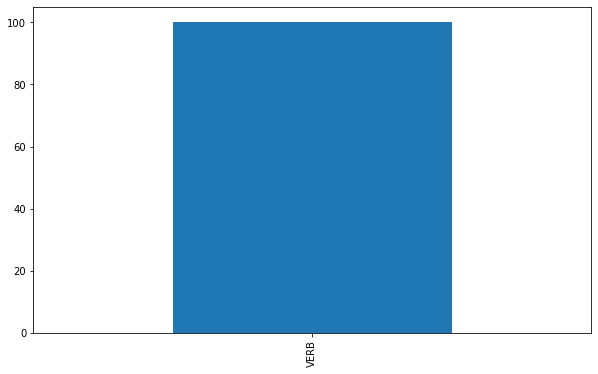

In [59]:
check_pattern('ould',train_set)

**Rule : Tag words ending with 'ould' as VERB**

NOUN    97.40
VERB     2.48
ADJ      0.12
Name: tags, dtype: float64

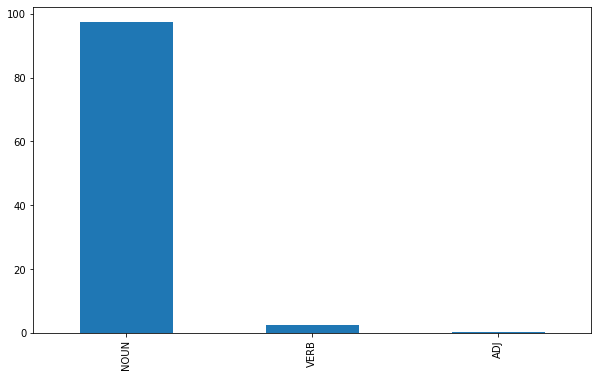

In [60]:
check_pattern('ers',train_set)

**Rule : Tag words ending with 'ers' as NOUN**

ADJ     92.31
NOUN     6.92
VERB     0.77
Name: tags, dtype: float64

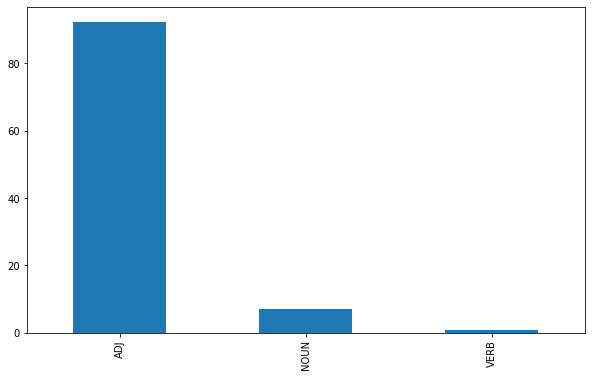

In [61]:
check_pattern('able',train_set)

**Rule : Tag words ending with 'able' as ADJ**

### Regex or Rule based Tagger

From above graphs, few rules can be made
- Any word ending with *ould* can be tagged as a VERB 100%
- Any word ending with *ness* can be tagged as a NOUN 99.09%
- Any word ending with *tion* can be tagged as a NOUN  98.28%
- Any word ending with *ers* can be tagged as a NOUN 97.40%
- Any word ending with *ful* can be tagged as a ADJ 94.12%
- Any word ending with *able* can be tagged as a ADJ 92.31%
- Any word ending with *ed* can be tagged as a VERB 87.69%
- Any word ending with *ly* can be tagged as a ADV 83.54%
- Any word ending with *es* can be tagged as a NOUN 83%
- Any word ending with *al* can be tagged as a ADJ 64.79%
- Any word ending with *ing* can be tagged as a VERB 58%
- Any word ending with *less* can be tagged as a ADJ 54.05%
- Any word ending with *er* can be tagged as a NOUN 51.80%

Techniques can use any of the approaches discussed in the class - lexicon, rule-based, probabilistic etc. Note that to implement these techniques, you can either write separate functions and call them from the main Viterbi algorithm, or modify the Viterbi algorithm, or both.

### Unigram Tagger: Lexicon Tagging

In [62]:
unigram_tagger = nltk.UnigramTagger(train_set)
accuracy_unigram_tagger = unigram_tagger.evaluate(test_set)
print("The accuracy of the Unigram Tagger is -", accuracy_unigram_tagger)


The accuracy of the Unigram Tagger is - 0.9101626016260163


### Bigraam Tagger

In [63]:
bigram_tagger = nltk.BigramTagger(train_set)
accuracy_bigram_tagger=bigram_tagger.evaluate(test_set)
print("The accuracy of the Bigram Tagger is -", accuracy_bigram_tagger)

The accuracy of the Bigram Tagger is - 0.21300813008130082


### Rule Based Tagger

In [64]:
# Patterns for tagging using a rule based tagger
regex_pattern_list = [
    (r'.*ould$','VERB'),
    (r'.*ness$','NOUN'),
    (r'.*tion$','NOUN'),
    (r'.*ers$','NOUN'),
    (r'.*ful$','ADJ'),
    (r'.*able$','ADJ'),
    (r'.*ed$','VERB'),
    (r'.*ly$','ADV'),
    (r'.*es$','NOUN'),
    (r'.*al$','ADJ'),
    (r'.*ing$','VERB'),
    (r'.*less$','ADJ'),
    (r'.*er$','NOUN'),
    (r'[0-9]+.?[0-9]*$','NUM'),
    (r'.*$','NOUN')
]

In [65]:
regex_tagger = nltk.RegexpTagger(regex_pattern_list)
accuracy_regex_tagger= regex_tagger.evaluate(test_set)
print("The accuracy of the Regex Tagger is -", accuracy_regex_tagger)

The accuracy of the Regex Tagger is - 0.36239837398373986


## Viterbi Modification - using LEXICON TAGGER

In [66]:
# Combining the regex tagger , unigram and bigram tagger backing off
def lexicon_tagger(paired_list):
    reg_tagger = nltk.RegexpTagger(regex_pattern_list)
    uni_tagger = nltk.UnigramTagger(paired_list,backoff=reg_tagger)
    bi_tagger = nltk.BigramTagger(paired_list,backoff=uni_tagger)
    return bi_tagger

In [67]:
combined_tagger = lexicon_tagger(train_set)
accuracy_combined_tagger= regex_tagger.evaluate(test_set)
print("The accuracy of the Lexicon Tagger is -", accuracy_combined_tagger)

The accuracy of the Lexicon Tagger is - 0.36239837398373986


In [68]:
def viterbi_with_lexicon_tagger(words, paired=tagged_training_words):
        tags = list(set([tag for (word,tag) in paired]))
        state_list = []
        unknown_word_tag_sent = lexicon_tagger(train_set).tag(words)
        for index,word in enumerate(words):
                try:
                        state_prob_list = []
                        for tag in tags:
                                 # compute emission probability for word
                                 e_prob = e_prob = emission_prob_dataframe.loc[word.lower(),tag]
                                 # get previous tag
                                 prev_tag= state_list[index-1] if index else '.'
                                 # compute transition probability
                                 t_prob = transition_prob_dataframe.loc[prev_tag,tag]
                                 # Calculate state probability 
                                 state_prob =  e_prob * t_prob
                                 state_prob_list.append(state_prob)

                        # find the max probability out of all state probability
                        max_prob = max(state_prob_list)
                        state_list.append(tags[state_prob_list.index(max_prob)])
                except:
                        # get tag for unknown words using tagger created by combination of rule based, unigram and bigram tagger
                        state_list.append(unknown_word_tag_sent[index][1])             
                      
        return list(zip(words,state_list))

In [135]:
# Let's test our Viterbi algorithm on a few sample sentences of test dataset
start_time = time.time()
viterbi_lexicon_sequence_list = []

for sentence in test_set:
    sequence = viterbi_with_lexicon_tagger([word for (word,tag) in sentence])
    viterbi_lexicon_sequence_list.append(sequence)

end_time = time.time()

# calculate time taken to execute
time_diff = end_time - start_time
runtime_for_viterbi_lexicon_tagger = round(time_diff,4)
print("Runtime for Viterbi with LExicon Tagger", runtime_for_viterbi_lexicon_tagger) 

Runtime for Viterbi with LExicon Tagger 618.5161


In [136]:
# Flaten the viterbi list
viterbi_lexicon_tagger_list = flatten_viterbi_list(bigram_tagger_sequence_list)
# Create tagged test dataframe of words for assigned and actual tags
viterbi_lexicon_tagger_dataframe = create_tagged_test_df(test_set,viterbi_lexicon_tagger_list)
viterbi_lexicon_tagger_dataframe.head()

,Word,Assigned_Tag,Original_Tag
0,In,ADP,ADP
1,the,DET,DET
2,U.S.,NOUN,NOUN
3,over-the-counter,ADJ,ADJ
4,market,NOUN,NOUN


In [137]:
# Calculate the accuracy of Bigram Tagger Viterbi
accuracy_for_viterbi_lexicon_tagger = get_accuracy(bigram_viterbi_tagger_dataframe)
print("ACCURACY: "+str(accuracy_for_viterbi_lexicon_tagger) +"%")

ACCURACY: 94.9%


## Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [138]:
accuracy_list = [('Vanilla Viterbi',accurancy_for_vanilla_viterbi,runtime_for_viterbi_vanilla),
('Viterbi for Unknown words with tansition proabability only',accuracy_for_viterbi_unknown_word,accuracy_for_viterbi_unknown_word),
('Viterbi with Lexicon Tagger',accuracy_for_viterbi_lexicon_tagger,runtime_for_viterbi_lexicon_tagger)]

In [139]:
accuracy_dataframe = pd.DataFrame(accuracy_list, columns=['Method','Accuracy(%)','Runtime(s)'])
accuracy_dataframe

,Method,Accuracy(%),Runtime(s)
0,Vanilla Viterbi,90.98,218.5724
1,Viterbi for Unknown words with tansition proab...,93.31,93.3100
2,Viterbi with Lexicon Tagger,94.90,618.5161


### Viterbi with Lexicon Tagger has the highest accuracy

## List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [140]:
with open('Test_Sentences.txt','r') as file:
    text_sentences = file.readlines()

text_sentences

['Android is a mobile operating system developed by Google.\n',
 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.\n',
 "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.\n",
 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.\n',
 'Before entering politics, Donald Trump was a domineering businessman and a television personality.\n',
 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.\n',
 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.\n',
 'Show me the cheapest round trips from Dallas to Atlanta\n',
 'I would like to see flights from Denver to Philadelphia.\n',
 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.\n',
 'NASA invited social medi

In [141]:
# append the sentences to viterbi list to test
vanilla_output_list= []
for sentence in text_sentences:
  sequence = vanilla_viterbi(word_tokenize(sentence))
  vanilla_output_list.append(sequence)

vanilla_output_list[:2]

[[('Android', 'DET'),
  ('is', 'VERB'),
  ('a', 'DET'),
  ('mobile', 'ADJ'),
  ('operating', 'NOUN'),
  ('system', 'NOUN'),
  ('developed', 'VERB'),
  ('by', 'ADP'),
  ('Google', 'DET'),
  ('.', '.')],
 [('Android', 'DET'),
  ('has', 'VERB'),
  ('been', 'VERB'),
  ('the', 'DET'),
  ('best-selling', 'ADJ'),
  ('OS', 'DET'),
  ('worldwide', 'DET'),
  ('on', 'ADP'),
  ('smartphones', 'DET'),
  ('since', 'ADP'),
  ('2011', 'DET'),
  ('and', 'CONJ'),
  ('on', 'ADP'),
  ('tablets', 'NOUN'),
  ('since', 'ADP'),
  ('2013', 'DET'),
  ('.', '.')]]

In [142]:
lexicon_output_list = []
for sentence in text_sentences:
    sequence = bigram_tagger_viterbi(word_tokenize(sentence))
    lexicon_output_list.append(sequence)

lexicon_output_list[:2]

[[('Android', 'NOUN'),
  ('is', 'VERB'),
  ('a', 'DET'),
  ('mobile', 'ADJ'),
  ('operating', 'NOUN'),
  ('system', 'NOUN'),
  ('developed', 'VERB'),
  ('by', 'ADP'),
  ('Google', 'NOUN'),
  ('.', '.')],
 [('Android', 'NOUN'),
  ('has', 'VERB'),
  ('been', 'VERB'),
  ('the', 'DET'),
  ('best-selling', 'ADJ'),
  ('OS', 'NOUN'),
  ('worldwide', 'NOUN'),
  ('on', 'ADP'),
  ('smartphones', 'NOUN'),
  ('since', 'ADP'),
  ('2011', 'NUM'),
  ('and', 'CONJ'),
  ('on', 'ADP'),
  ('tablets', 'NOUN'),
  ('since', 'ADP'),
  ('2013', 'NUM'),
  ('.', '.')]]

In [143]:
unknown_word_output_list=[]
for sentence in text_sentences:
    sequence = viterbi_for_unknown_words(word_tokenize(sentence))
    unknown_word_output_list.append(sequence)

unknown_word_output_list[:2]

[[('Android', 'NOUN'),
  ('is', 'VERB'),
  ('a', 'DET'),
  ('mobile', 'ADJ'),
  ('operating', 'NOUN'),
  ('system', 'NOUN'),
  ('developed', 'VERB'),
  ('by', 'ADP'),
  ('Google', 'DET'),
  ('.', '.')],
 [('Android', 'NOUN'),
  ('has', 'VERB'),
  ('been', 'VERB'),
  ('the', 'DET'),
  ('best-selling', 'ADJ'),
  ('OS', 'NOUN'),
  ('worldwide', 'NOUN'),
  ('on', 'ADP'),
  ('smartphones', 'DET'),
  ('since', 'ADP'),
  ('2011', 'DET'),
  ('and', 'CONJ'),
  ('on', 'ADP'),
  ('tablets', 'NOUN'),
  ('since', 'ADP'),
  ('2013', 'DET'),
  ('.', '.')]]

In [144]:
# Flaten the viterbi list
vanilla_list = flatten_viterbi_list(vanilla_output_list)
lexicon_tagger_list = flatten_viterbi_list(lexicon_output_list)
unknown_word_list = flatten_viterbi_list(unknown_word_output_list)

# Create common dataframe
common_list = list(set([(vword,vtag,utag, btag) for (vword,vtag) in vanilla_list for (bword,btag) in lexicon_tagger_list for (uword,utag) in unknown_word_list if (vword==bword) and (bword==uword)]))

common_df = pd.DataFrame(common_list,columns=['Word','Vanilla Viterbi Tag', 'Viterbi with only transition prob for unknown word Tag', 'Viterbi with Lexicon Tag'])

common_df.sample(20,random_state=55)

,Word,Vanilla Viterbi Tag,Viterbi with only transition prob for unknown word Tag,Viterbi with Lexicon Tag
67,that,ADP,ADP,ADP
41,by,ADP,ADP,ADP
116,trips,DET,NOUN,NOUN
99,at,ADP,ADP,ADP
79,tweets,DET,DET,NOUN
40,is,VERB,VERB,VERB
113,tablets,NOUN,NOUN,NOUN
23,FIFA,DET,NOUN,NOUN
80,This,DET,DET,DET
9,contested,DET,NOUN,VERB


Observations:


There were several words which were not correctly tagged by the Vanilla Viterbi but after improvising the algorithms they were correctly tagged.


- **'Vanilla Viterbi'** tagged some of the words incorrectly like 'trips','tweets','worldwide','smartphone','contested','FIFA' with 'DET'.
-  **'Viterbi with only transition probability for unknown words'** correctly tagged few of these words like 'worldwide','trips','FIFA' as NOUN but failed to tag rest correctly and tagged them as DET and 'contested' as NOUN 
- **'Vanilla with Lexicon Tagger'** was able to correctly tag 'trips','tweets','worldwide','smartphone','FIFA' with NOUN and 'contested' as VERB




# SUMMARY:

- 'Viterbi with Lexicon tagger' has the best accuracy of about 95% followed by 'Viterbi with only transition prob for unknown word Tag' and then 'Vanilla Viterbi'
- Although 'Viterbi with Lexicon Tagger' has best accuracy, yet the runtime/prediction time was the highest for it (around 6 times the 'Viterbi with only transition prob for unknown word Tag')
- 'Vanilla Viterbi' was not able to assign the correct tags for words like trips, tweets, contested. We observed that a default tag of DET was assigned to all the aforementioned words.
- 'Vanilla with Lexicon Tagger' was able to correctly tag 'trips','tweets','worldwide','smartphone','FIFA' with NOUN and 'contested' as VERB